# Unit 06

`````{tab-set}
````{tab-item} Objective

::::{important} Objective

In this hands-on session, the objective is to perform **supervised classification** of dyes into the categories *cyanines* and *acridines* based on both structural and/or electronic features.

- To achieve this, first create two scalar (single-value) invariant features from the given dataset.
- Apply different methods of your choice (*e.g.*, **k-Nearest Neighbors, Logistic Regression, and Random Forest Classifier**) to group the dyes based on this electronic descriptor.
- What is the maximum accuracy you can achieve? What are the features and which with method? (Send this final result to Prof. Müller vis Mail)

In this example, we will analyze a dataset containing class labels for 40 dyes, with one molecule missing a class label. Our goal is to train classification models that not only accurately describe the training and test data but also predict the class label for the one sample where it is missing.

The reference data for training is obtained from [PhotochemCAD](https://www.photochemcad.com/).

::::

````


````{tab-item} Further Information

:::{admonition}Further Information


**pandas** and **pandas.DataFrame**
- [`pandas.DataFrames` (1)](https://pandas.pydata.org/docs/user_guide/10min.html)
- [`pandas.DataFrames` (2)](https://www.w3schools.com/python/pandas/pandas_dataframes.asp)
- [`pandas.DataFrames` (3)](https://www.datacamp.com/tutorial/pandas-tutorial-dataframe-python)

**sklearn**
- [k-Nearest Neighbours](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- [Support Vector Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

- [`Pipelines`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
- [Decision Boundaries](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html)
- [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- [Pipelining and grid search](https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html#pipelining)

:::

````
`````


In [2]:
# general packages which are might required
import pickle, sys, os
import numpy as np
import pandas as pd

# packages for plotting
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import digichem as dc
from digichem import FP, Spectrum
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.linear_model import LogisticRegression

In [25]:
# load data from pickle file
with open('df_acridines_cyanines_unknownpkl.pkl', 'rb') as handle:
    df = pickle.load(handle)

df.head(n=5)

/tmp/ipykernel_7374/3902306003.py:3: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  df = pickle.load(handle)


,dye_category,smiles,abs_max,abs_spec
K01,cyanines,CCN1/C(=C/c2ccc3ccccc3[n+]2CC)C=Cc2ccccc21,524.25,"220.0 to 900.0 nm, steps: 1.0 nm"
K02,cyanines,CCN1/C(=C/C=C/c2ccc3ccccc3[n+]2CC)C=Cc2ccccc21,603.50,"220.0 to 900.0 nm, steps: 1.0 nm"
K03,cyanines,CCN1/C(=C/C=C/C=C/c2ccc3ccccc3[n+]2CC)C=Cc2ccc...,711.00,"220.0 to 900.0 nm, steps: 1.0 nm"
K04,cyanines,CCN1C=C/C(=C\c2cc[n+](CC)c3ccccc23)c2ccccc21,592.00,"220.0 to 900.0 nm, steps: 1.0 nm"
K05,cyanines,CCN1C=C/C(=C\C=C\c2cc[n+](CC)c3ccccc23)c2ccccc21,709.50,"220.0 to 900.0 nm, steps: 1.0 nm"


## A) Inspection and pre-processing of data

::::{tip} Task 6.1 - Feature Generation and Selection

While machine learning models can easily handle multidimensional features (such as vectors, arrays, or tensors), in this exercise we will focus on only two scalar (single-value) invariant features. This restriction will allow us to visualize decision boundaries effectively.

As in any machine learning task, feature selection is flexible and can be done in many ways. You are free to choose any two features you can derive — for example:

- From the **absorption spectrum** (*e.g.*, the position of a local maximum or the integral over a specific wavelength range), or
- From the molecular **structure** (available as SMILES strings in the dataset).

::::

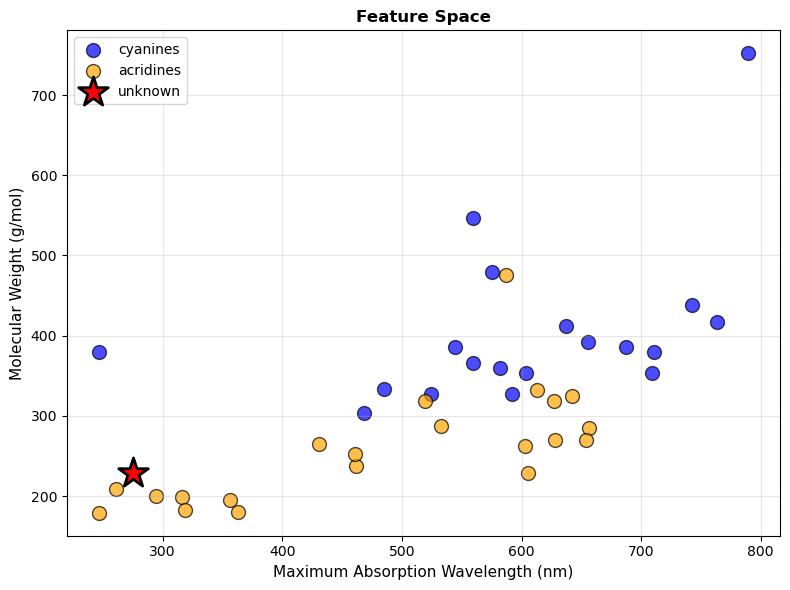

In [26]:



def get_molecular_weight(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return Descriptors.MolWt(mol) if mol else np.nan

df['mol_weight'] = df['smiles'].apply(get_molecular_weight)

# Prepare data for ML
X_all = df[['abs_max', 'mol_weight']].copy()
y_all = df['dye_category'].copy()

# Separate labeled and unlabeled
X_labeled = X_all[y_all != 'unknown']
y_labeled = y_all[y_all != 'unknown']
X_unknown_sample = X_all[y_all == 'unknown']

# Visualize feature space
df_labeled = df[df['dye_category'] != 'unknown']
df_unknown = df[df['dye_category'] == 'unknown']

plt.figure(figsize=(8, 6))
colors = {'cyanines': 'blue', 'acridines': 'orange'}

for category in ['cyanines', 'acridines']:
    subset = df_labeled[df_labeled['dye_category'] == category]
    plt.scatter(subset['abs_max'], subset['mol_weight'], 
                c=colors[category], label=category, alpha=0.7, s=100, edgecolors='black')

plt.scatter(df_unknown['abs_max'], df_unknown['mol_weight'], 
            c='red', label='unknown', marker='*', s=500, edgecolors='black', linewidths=2)

plt.xlabel('Maximum Absorption Wavelength (nm)', fontsize=11)
plt.ylabel('Molecular Weight (g/mol)', fontsize=11)
plt.title('Feature Space', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




::::{tip} Task 6.2 - Data Splitting

Prior to the supervised machine learning for classification, we have to split our data into a set of training and test data and furthermore prepare the unlabelled data point:

Please create a ```pd.DataFrame``` of the labeled data, including two columns for the features derived from the absorption spectra of the dyes.
Additionally, create a ```pd.Series``` for the respective labels (`acridines` or `cyanines`).

Ensure that the unlabeled data point is separated from the original dataset and is not included in either the training or test sets. 
Prepare this unlabeled data point in a similar pd.DataFrame format, as it will be used to predict the label using our trained model.

:::{admonition} Data Splitting (sklearn)
:class: dropdown

Before performing supervised machine learning for classification, it is crucial to properly split your data into training and test sets to evaluate the model's performance accurately. This ensures that the model generalizes well to new, unseen data. Improper data splitting can lead to misleading performance metrics and overfitting.

Typically, 70-80% of the data is used for training, and the remaining 20-30% is used for testing. This balance allows the model to learn effectively while having enough data to validate its performance.

To split your data in Python using scikit-learn, you can use the train_test_split function. Here is an example:

```{code-block} python
:lineno-start: 1
:emphasize-lines: 4

from sklearn.model_selection import train_test_split

# Assuming 'X' is your DataFrame of features and 'y' is your Series of labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 'test_size=0.2' means 20% of the data will be used for testing
```

:::

::::

In [27]:
from sklearn.model_selection import train_test_split

# Make sure to only include acridines and cyanines in the training/test data

X_train, X_test, y_train, y_test = train_test_split(
    X_labeled,  # This already excludes 'unknown'
    y_labeled,  # This already excludes 'unknown'
    test_size=0.2, 
    random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Unknown sample: {X_unknown_sample.shape[0]} sample")

# Verify: Check that 'unknown' is NOT in training or test sets
print(f"\nClasses in training: {y_train.unique()}")
print(f"Classes in test: {y_test.unique()}")\


# Check class distribution
print("Training set distribution:")
print(y_train.value_counts())

print("\nTest set distribution:")
print(y_test.value_counts())


Training set: 32 samples
Test set: 8 samples
Unknown sample: 1 sample

Classes in training: ['acridines' 'cyanines']
Classes in test: ['acridines' 'cyanines']
Training set distribution:
dye_category
acridines    17
cyanines     15
Name: count, dtype: int64

Test set distribution:
dye_category
acridines    4
cyanines     4
Name: count, dtype: int64


## B) Supervised Classification



:::::{tip} Task 6.3 - Supervised Classification

The objective in this section is to train different classifiers to distinguish acridines and cyanines based on the two features extracted from the absorption data of the respective dyes.

::::{admonition} Example: kNN model
:class: dropdown

The standard workflow in working with sklearn models, can be described as follows using the example of kNN:

STEP 1 - Import Libraries 
: We start by importing necessary classes from scikit-learn. These include KNeighborsClassifier for the kNN algorithm, Pipeline to streamline the preprocessing and modeling steps, and StandardScaler to standardize the features.

```{code-block} python
:lineno-start: 1
:emphasize-lines: 2,3

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
```

STEP 2 - Define the Scaler
: We create an instance of StandardScaler which standardizes features by removing the mean and scaling to unit variance. This is an essential preprocessing step to ensure the kNN algorithm performs well, as it relies on distance calculations.

```{code-block} python
:lineno-start: 4
:emphasize-lines: 5

# define scaling (mean=0, variance=1)
scaler = StandardScaler()
```

STEP 3 - Define the kNN Model
: We instantiate the KNeighborsClassifier with n_neighbors=2, which means the algorithm will consider the 2 nearest neighbors to make a classification decision.

```{code-block} python
:lineno-start: 6
:emphasize-lines: 7

# kNN considering 2 nearest neighhbors for classification
knn = KNeighborsClassifier(n_neighbors=2)
```

STEP 4 - Create a Pipeline
: We combine the scaler and kNN model into a pipeline. This ensures that the data is first scaled before being passed to the kNN classifier. The pipeline helps in maintaining a clean and efficient workflow.

```{code-block} python
:lineno-start: 8
:emphasize-lines: 9

# pipeline combining scaling and kNN model 
knn_clf = Pipeline(steps=[("scaler", scaler), ("knn", knn)])
```

STEP 5 - Fit the Model
: We fit the pipeline to the training data (X_train and y_train). In this context, fitting means the scaler will compute the mean and variance from the training data, which will be used to transform the data. The kNN model will then use this transformed data for making predictions.

```{code-block} python
:lineno-start: 10
:emphasize-lines: 11

# train model (remember: kNN has no training but is instance-based/lazy learner)
knn_clf.fit(X_train, y_train)
```

:::{admonition} Complete Code
:class: dropdown

```{code-block} python
:lineno-start: 1
:emphasize-lines: 12

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# define scaling (mean=0, variance=1)
scaler = StandardScaler()

# kNN considering 2 nearest neighhbors for classification
knn = KNeighborsClassifier(n_neighbors=2)

# pipeline combining scaling and kNN model 
knn_clf = Pipeline(steps=[("scaler", scaler), ("knn", knn)])

# train model (remember: kNN has no training but is instance-based/lazy learner)
knn_clf.fit(X_train, y_train)
```
:::

:::{admonition} Finding the Optimal k-Value for kNN Classification
:class: dropdown

Upon fitting the kNN model with a specific k-value, you can access the score, which indicates how accurately the model classifies the labeled data. For example, a score of 1.0 on the test set means the model correctly classified every test data point.

In python you can access the scores and predictions with the score and predcit functions:

```{code-block} python
:lineno-start: 12

# score (function takes features and labels and returns score)
knn_clf.score(X_test, y_test)

# prediction (function takes only features and returns a label)
knn_clf.score(X_sample)
```

To find the optimal k-value, perform kNN classification for various k-values and evaluate their scores. By comparing these scores, you can determine the best k-value for your model.
Instructions:

1. Perform kNN classification for a range of k-values.
2. Calculate the scores for both the training and test data for each k-value.
3. Visualize how the scores on the test and training data depend on the k-value.
3. Based on the visualization, choose the optimal k-value.

:::

::::

::::{admonition} Assessing the Model's Quality
:class: dropdown

Now that we have chosen the optimal k-value, we will train a kNN model using this value and analyze its performance. To do this, we will examine two different measures: the confusion matrix and decision boundaries.

1. Train the kNN model using the optimal k-value.
2. Generate and analyze the confusion matrix for the test data.
3. Visualize the decision boundaries of the trained model. Visualize the data point with unknown label. Is the model able to describe the class of this dye correct?

:::{admonition} Confusion Matrix
:class: dropdown

The confusion matrix is a table that summarizes the performance of a classification algorithm. It shows the number of correct and incorrect predictions made by the model compared to the actual classifications. Each row of the matrix represents the instances in an actual class, while each column represents the instances in a predicted class. This matrix helps to assess the model's quality by providing insights into its accuracy, precision, recall, and ability to distinguish between different classes.

```{code-block} python
:lineno-start: 1
:emphasize-lines: 6

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# create confusion matrix
cm = confusion_matrix(y_test, knn_clf.predict(X_test))

# convert array into pd.DataFrame
cm_matrix = pd.DataFrame(
    data=cm, 
    columns=['Actual: Acridine', 'Actual: Cyanine'], 
    index=['Predict: Acridine', 'Predict: Cyanine']
)

# visualize the confusion matrix as heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='rocket_r')
```
:::

:::{admonition} Decision Boundaries
:class: dropdown

Decision boundaries are the surfaces that separate different classes predicted by the model. In the context of kNN, these boundaries illustrate how the algorithm divides the feature space based on the training data. Visualizing decision boundaries helps to assess the model's quality by showing how well the model generalizes to new data and how it handles different regions of the feature space. It can reveal whether the model is overfitting or underfitting the data.

```{code-block} python
:lineno-start: 1
:emphasize-lines: 4,5,6,7,8,9,10

from sklearn.inspection import DecisionBoundaryDisplay

# compute and visualize descion boundaries from the classifier
disp = DecisionBoundaryDisplay.from_estimator(
    knn_clf, 
    X_all.values, 
    response_method="predict",
    xlabel='feature 1', 
    ylabel='feature 2',
)

# indicate class by color in scatterplot
color_mapping = {'cyanines': 'blue', 'acridines': 'orange'}
colors = [color_mapping[label] for label in y_all]

disp.ax_.scatter(X_all['feature 1'].values, X_all['feature 2'].values, c=colors)
```
:::
::::

:::::

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [5]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression
lr_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(random_state=42))
])

lr_model.fit(X_train, y_train)

# Evaluate
print(f"Logistic Regression Training Accuracy: {lr_model.score(X_train, y_train):.3f}")
print(f"Logistic Regression Test Accuracy: {lr_model.score(X_test, y_test):.3f}")

NameError: name 'X_train' is not defined

Final kNN Test Accuracy: 0.875


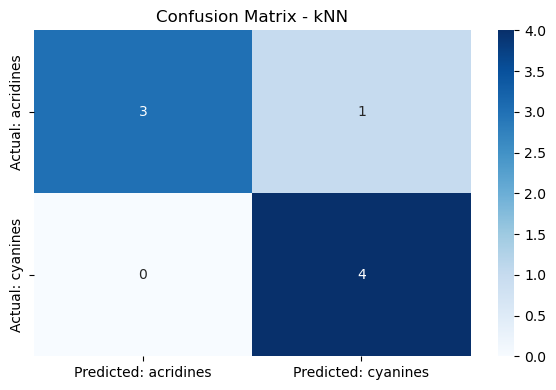

In [30]:
from sklearn.metrics import confusion_matrix

# plot confusion matrix for test / training data

# Train final kNN model with optimal k
knn_final = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=optimal_k))
])

knn_final.fit(X_train, y_train)

# Evaluate on test set
y_pred = knn_final.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Final kNN Test Accuracy: {accuracy:.3f}")


cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, 
                     columns=['Predicted: acridines', 'Predicted: cyanines'],
                     index=['Actual: acridines', 'Actual: cyanines'])

plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - kNN')
plt.tight_layout()
plt.show()


/home/hatef/miniconda3/envs/rdkit-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


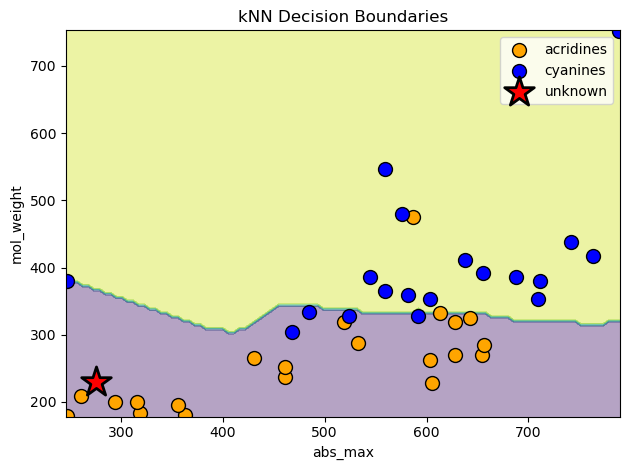


Prediction for unknown sample: acridines


In [31]:
from sklearn.inspection import DecisionBoundaryDisplay

# plot decision boundaries

# Decision Boundaries
from sklearn.inspection import DecisionBoundaryDisplay

# Combine train and test for visualization
X_all_labeled = pd.concat([X_train, X_test])
y_all_labeled = pd.concat([y_train, y_test])

# Create decision boundary plot
disp = DecisionBoundaryDisplay.from_estimator(
    knn_final,
    X_all_labeled.values,
    response_method="predict",
    xlabel='abs_max',
    ylabel='mol_weight',
    alpha=0.4
)

# Plot the data points
colors = {'acridines': 'orange', 'cyanines': 'blue'}
for category in ['acridines', 'cyanines']:
    mask = y_all_labeled == category
    disp.ax_.scatter(X_all_labeled[mask].iloc[:, 0], 
                     X_all_labeled[mask].iloc[:, 1],
                     c=colors[category], label=category, 
                     edgecolors='black', s=100)

# Plot unknown sample
disp.ax_.scatter(X_unknown_sample.iloc[0, 0], 
                 X_unknown_sample.iloc[0, 1],
                 c='red', marker='*', s=500, 
                 edgecolors='black', linewidths=2, label='unknown')

plt.legend()
plt.title('kNN Decision Boundaries')
plt.tight_layout()
plt.show()

# Predict the unknown sample
unknown_prediction = knn_final.predict(X_unknown_sample)
print(f"\nPrediction for unknown sample: {unknown_prediction[0]}")

:::::{tip} Task 6.4 - Choose a model for the task/dataset 

Now that you have configured classifiers with optimized hyperparameters, let's use these models to predict the class of the unlabelled data point. Examine the details of the unlabelled molecule and determine if the models accurately classify its class.

What is your classification result? Are your models suited for performing classification based on the chosen two features considering that the unknown compound should be classified as acridine?

:::::

In [32]:
# model predictions for unlabelled data - acridines is correct
# Model predictions for unlabelled data - acridines is correct
unknown_prediction = knn_final.predict(X_unknown_sample)

print(f"Prediction for unknown sample: {unknown_prediction[0]}")
print(f"\nThe model predicts: {unknown_prediction[0]}")
print(f"Correct answer: acridines")
print(f"Model is correct: {unknown_prediction[0] == 'acridines'}")

Prediction for unknown sample: acridines

The model predicts: acridines
Correct answer: acridines
Model is correct: True
